<a href="https://colab.research.google.com/github/yasminmufidah/Face-Generation-GAN/blob/main/Generate_Human_Face_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.layers import Input, Dense, Reshape, Flatten
from keras.models import Model

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-23__4sro
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-23__4sro
  Resolved https://github.com/tensorflow/docs to commit ec765851b8312bdc4dcf685e41020ce568c7bff2
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=8f5d2c60a1c4bbbea7ab817a1a9f3185e2302cc0d8226c5d84b54d9f6b14e15c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1q1zgbkb/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
from PIL import Image
import glob
import imageio
from IPython import display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset


 99% 1.32G/1.33G [00:12<00:00, 162MB/s]
100% 1.33G/1.33G [00:12<00:00, 114MB/s]


In [ ]:
!unzip -q celeba-dataset.zip

Number of images: 202599


<Figure size 1200x800 with 0 Axes>

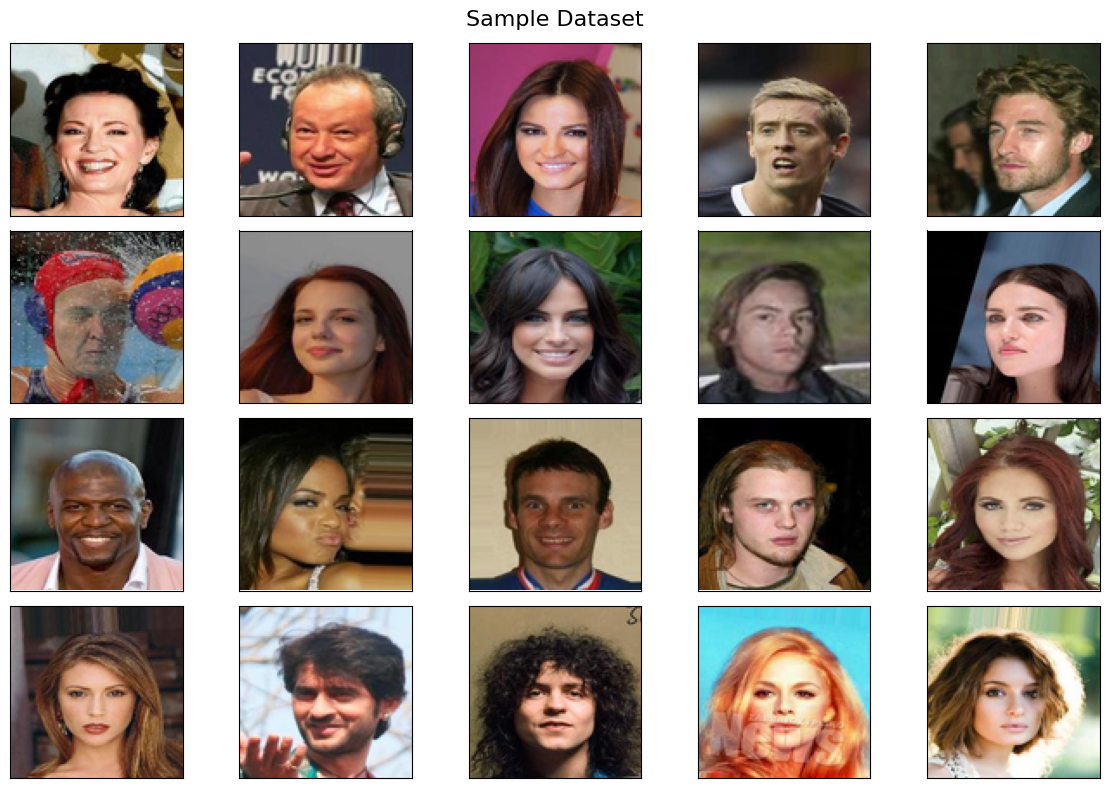

In [ ]:
dataset_path = '/content/img_align_celeba/img_align_celeba'
image_files = [f for f in os.listdir(dataset_path)]
print(f"Number of images: {len(image_files)}")

def explore_dataset(dataset_path):
    plt.figure(figsize=(12,8))
    fig, axes = plt.subplots(4, 5, figsize=(12, 8))
    fig.suptitle('Sample Dataset', fontsize=16)
    axes = axes.flatten()

    for i, img_file in enumerate(image_files[:20]):
        img_path = os.path.join(dataset_path, img_file)
        img = Image.open(img_path)
        img = img.resize((100, 100), Image.LANCZOS)
        axes.flatten()[i].imshow(img)
        axes.flatten()[i].set_xticks([])
        axes.flatten()[i].set_yticks([])
        plt.tight_layout()

explore_dataset(dataset_path)


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path, color_mode='rgb', batch_size=256,
    image_size=(64, 64), label_mode=None,
    shuffle=True, seed=42)

dataset = dataset.map(lambda x: x / 255.)

Found 202599 files belonging to 1 classes.


### Generator Model


In [ ]:
def build_generator():
  gen_inputs = Input(shape=(100,), name='generator_input')

  x = layers.Dense(8 * 8 * 3)(gen_inputs)
  x = layers.Reshape(target_shape=(8, 8, 3))(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=512, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), padding='same')(x)
  images = layers.LeakyReLU()(x)

  model = Model(inputs=gen_inputs, outputs=images)
  return model

In [ ]:
os.mkdir('/content/generated_images')

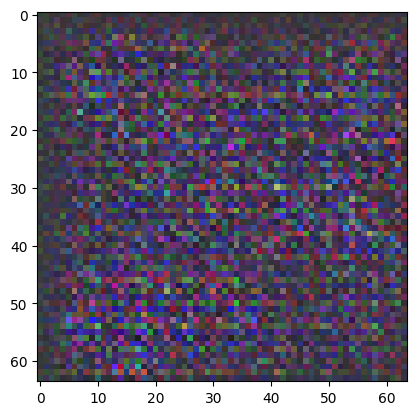

In [ ]:
generator = build_generator()
noise = tf.random.normal((1, 100))
image = generator(noise)
image = tf.keras.preprocessing.image.array_to_img(image[0].numpy())
path = '/content/generated_images'
tf.keras.preprocessing.image.save_img(f'{path}/deneme.jpg', image)
plt.imshow(image)
plt.show()



In [ ]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 dense (Dense)               (None, 192)               19392     
                                                                 
 reshape (Reshape)           (None, 8, 8, 3)           0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 3)           12        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 3)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         14336 

### Discriminator Model

In [ ]:
def build_discriminator():
  disc_inputs = Input(shape=(64, 64, 3), name='discriminator_input')
  x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same')(disc_inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1)(x)
  output = layers.Activation('sigmoid')(x)

  model = Model(inputs=disc_inputs, outputs=output)
  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 64, 64, 3)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                           

### Loss Function

In [ ]:
# loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


### TRAINING MODEL

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal((1, 100))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i] * 127.5
      img = np.clip(img, 0, 255)
      plt.imshow(img.astype('uint8'))
      plt.axis('off')

  plt.savefig('img_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
BATCH_SIZE = 256
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


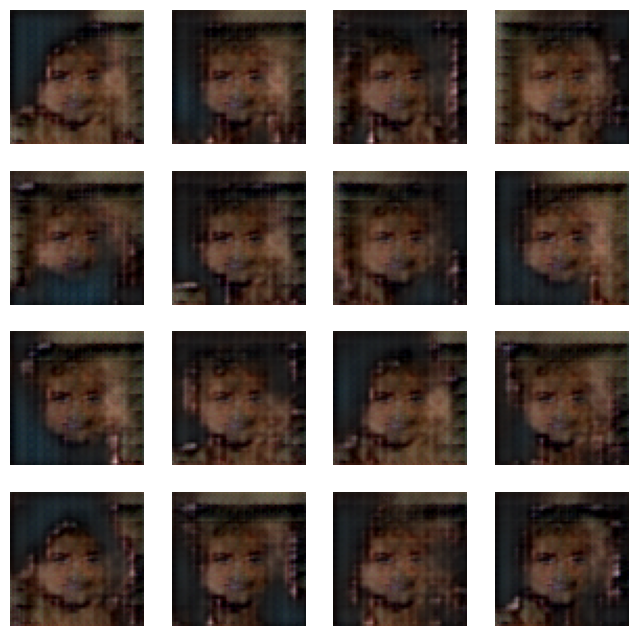

In [ ]:
train(dataset, EPOCHS)

### GENERATE IMAGE

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('img*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-42-079dcfb91d57>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-42-079dcfb91d57>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
from pathlib import Path

source_directory = '/content/'
target_directory = '/content/drive/MyDrive/GAN FACE GENERATOR/train1'

generated_files = [f'img_at_epoch_{str(i).zfill(4)}.png' for i in range(1, 51)]

for file_name in generated_files:
    source_path = Path(source_directory) / file_name
    target_path = Path(target_directory) / file_name
    shutil.copy(source_path, target_path)

gif_path = '/content/dcgan.gif'
shutil.copy(gif_path, target_path)
print("Files copied successfully.")


Files copied successfully.
